<center><h1>Saravanan_Praveen_HW2</h1></center>
<br>
<br>

Name: Praveen Saravanan
<br>
Github Username: Michael-on-the-Microphone
<br>
USC ID: 7939976839

## 1. Combined Cycle Power Plant Data Set

### (a) Download Data

Package imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor

Get the Cycle Power Plant Data Set

In [2]:
DATA_FILE = Path("../data/Folds5x2_pp.xlsx") 
df = pd.read_excel(DATA_FILE, sheet_name=0)

In [3]:
n_rows, n_cols = df.shape
print(f"Shape ➜  {n_rows:,d} rows  x  {n_cols} columns\n")
display(df.head())

Shape ➜  9,568 rows  x  5 columns



,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [4]:
feature_cols = ["AT", "V", "AP", "RH"]   
target_col   = "PE"                      
X = df[feature_cols]
y = df[target_col]

### (b) Exploring the data

#### i. rows and columns

9568 rows and 5 coloums. 
with each row representing a data point and each coloumn representing a feature.
The features are:
    Ambient Temperature -> AT
    Vacuum -> V
    Ambient Pressure -> AP
    Relative Humidity -> RH
    Produced Energy -> PE
5 sheets represent data for 5 years.

#### ii. pairwise scatterplots of all the varianbles

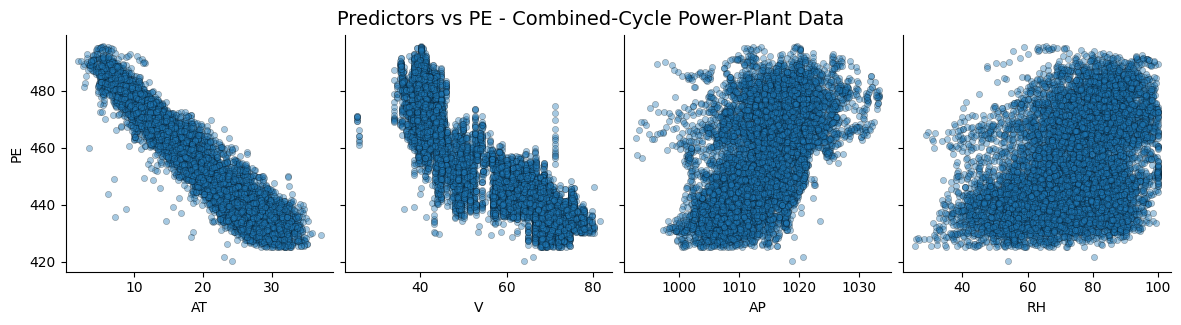

In [5]:

sns.pairplot(
    df,
    x_vars=feature_cols,  
    y_vars=target_col,                    
    kind="scatter",
    height=3,                         
    aspect=1,                        
    plot_kws={"alpha": 0.4, "edgecolor": "k", "s": 20},
)
plt.suptitle("Predictors vs PE - Combined-Cycle Power-Plant Data",
             y=1.05, fontsize=14)
plt.show()


- AT vs PE — hotter ambient temperature steadily reduces power output.
- V vs PE — greater condenser vacuum coincides with lower output after \~40 cm Hg.
- AP vs PE — barometric pressure has only a modest, noisy influence.
- RH vs PE — humidity adds a weak, nonlinear effect.

#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

In [6]:
stats = df.describe().T                      
stats["range"] = stats["max"] - stats["min"]
stats["IQR"]   = stats["75%"] - stats["25%"]

summary = (stats[["mean", "50%", "range", "25%", "75%", "IQR"]].rename(columns={"50%": "median", "25%": "Q1", "75%": "Q3"}).round(2))
display(summary)

,mean,median,range,Q1,Q3,IQR
AT,19.65,20.34,35.30,13.51,25.72,12.21
V,54.31,52.08,56.20,41.74,66.54,24.80
AP,1013.26,1012.94,40.41,1009.10,1017.26,8.16
RH,73.31,74.97,74.60,63.33,84.83,21.50
PE,454.37,451.55,75.50,439.75,468.43,28.68


### (c) Simple Linear Regression

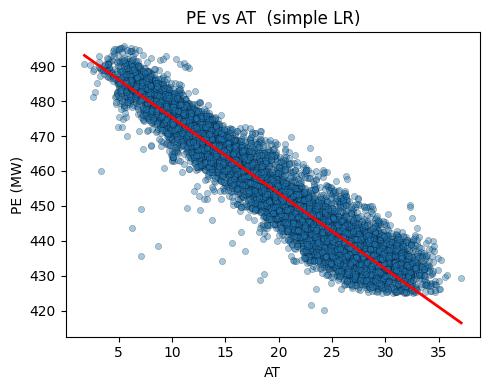

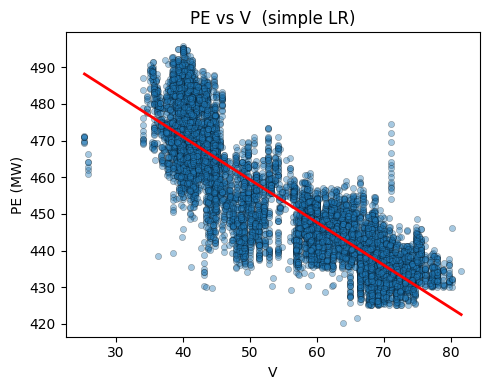

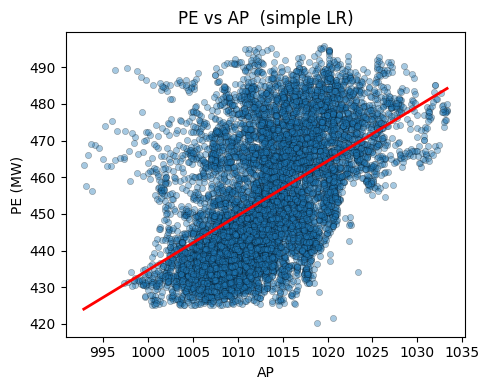

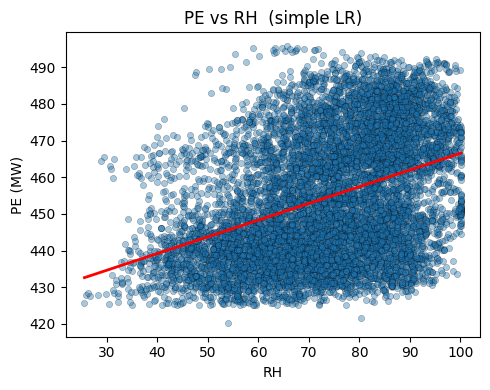

,slope,intercept,R²,p-value,std-err
Predictor,,,,,
AT,-2.171,497.03,0.899,0.00e+00,0.007
V,-1.168,517.80,0.757,0.00e+00,0.007
AP,1.490,-1055.26,0.269,0.00e+00,0.025
RH,0.456,420.96,0.152,0.00e+00,0.011


In [7]:
results = []  

for col in feature_cols:                
    slope, intercept, r_val, p_val, stderr = st.linregress(df[col], y)
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=df[col], y=y, alpha=0.4, edgecolor="k", s=20)
    x_line = np.linspace(df[col].min(), df[col].max(), 200)
    plt.plot(x_line, intercept + slope*x_line, color="red", lw=2)
    plt.title(f"PE vs {col}  (simple LR)")
    plt.xlabel(col)
    plt.ylabel("PE (MW)")
    plt.tight_layout()
    plt.show()

    results.append({
        "Predictor": col,
        "slope": round(slope, 3),
        "intercept": round(intercept, 2),
        "R²": round(r_val**2, 3),
        "p-value": f"{p_val:.2e}",
        "std-err": round(stderr, 3)
    })

slr_table = pd.DataFrame(results).set_index("Predictor")
display(slr_table)

All four predictors are statistically significant; practically AT dominates, V is meaningful, AP and RH are minor on their own.

Outliers to remove? none of the edge points are residual outliers—just high-leverage observations that extend the range—so I would retain the full data set for all four simple regressions.

### (d) Multiple Regression

In [8]:
X_mlr = sm.add_constant(df[feature_cols])   
y_mlr = df[target_col]

mlr_model = sm.OLS(y_mlr, X_mlr).fit()

mlr_summary = (
    mlr_model.summary2().tables[1]          
    .rename(columns={
        "Coef.": "betâ",
        "Std.Err.": "std-err",
        "P>|t|": "p-value"
    })
    .round({"betâ": 3, "std-err": 3, "t": 2, "p-value": 3})
)

display(mlr_summary)

r2   = mlr_model.rsquared
rmse = np.sqrt(mlr_model.mse_resid)

print(f"\nModel R²  = {r2:.3f}")
print(f"Residual RMSE = {rmse:.2f} MW")

,betâ,std-err,t,p-value,[0.025,0.975]
const,454.609,9.749,46.63,0.0,435.500123,473.718425
AT,-1.978,0.015,-129.34,0.0,-2.007483,-1.947543
V,-0.234,0.007,-32.12,0.0,-0.248191,-0.219642
AP,0.062,0.009,6.56,0.0,0.043543,0.080623
RH,-0.158,0.004,-37.92,0.0,-0.166225,-0.149883



Model R²  = 0.929
Residual RMSE = 4.56 MW


Because every predictor’s two-sided p-value is effectively 0.000 (well below any common α level such as 0.05 or 0.01), we reject the null hypothesis for all four predictors in the multiple regression model.

So each variable remains a statistically significant contributor to predicting net power output once the others are in the model.

### (e) 1c Compare to 1d

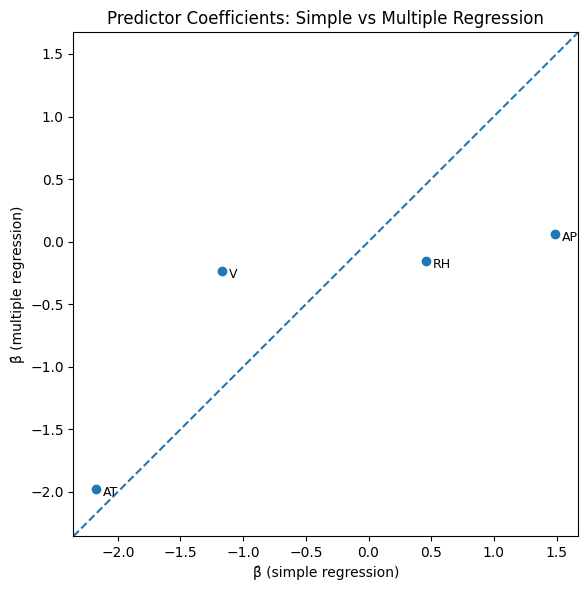

In [9]:
simple_betas = {col: st.linregress(df[col], y).slope for col in feature_cols} 

X_mlr = sm.add_constant(df[feature_cols]) 

multi_betas = sm.OLS(y, X_mlr).fit().params.drop("const")

x_vals = [simple_betas[c] for c in feature_cols]
y_vals = [multi_betas[c]  for c in feature_cols]

plt.figure(figsize=(6,6))
plt.scatter(x_vals, y_vals)                  
lims = plt.gca().get_xlim()
plt.plot(lims, lims, ls="--")               
plt.gca().set_xlim(lims); plt.gca().set_ylim(lims)
for col, xf, yf in zip(feature_cols, x_vals, y_vals): plt.annotate(col, (xf, yf), textcoords="offset points", xytext=(5,-5), fontsize=9)


plt.xlabel("β̂ (simple regression)")
plt.ylabel("β̂ (multiple regression)")
plt.title("Predictor Coefficients: Simple vs Multiple Regression")
plt.tight_layout()
plt.show()


In [10]:
simple_slopes = {col: st.linregress(df[col], df["PE"]).slope for col in ["AT", "V", "AP", "RH"]}

multi_betas = sm.OLS(df["PE"], sm.add_constant(df[["AT","V","AP","RH"]])).fit().params.drop("const")

print("Simple:", simple_slopes)
print("Multiple:", multi_betas.to_dict())


Simple: {'AT': np.float64(-2.171319958517793), 'V': np.float64(-1.1681351265557138), 'AP': np.float64(1.4898716733991144), 'RH': np.float64(0.45565010226297975)}
Multiple: {'AT': -1.977513106635394, 'V': -0.23391642258249845, 'AP': 0.06208294378085511, 'RH': -0.15805410291641303}


Points for AT and V lie just above the 45° line – their effects are still strong but are partially absorbed by the other predictor.

RH moves closer to the origin, showing its stand-alone slope was partly proxying for temperature and vacuum.

AP hovers almost on the origin in the multiple model, confirming its tiny unique contribution after AT, V, RH are in.

In short, the multiple model keeps the same story but tempers the magnitude of each slope to avoid double-counting shared information.

### (f) Nonlinear Association

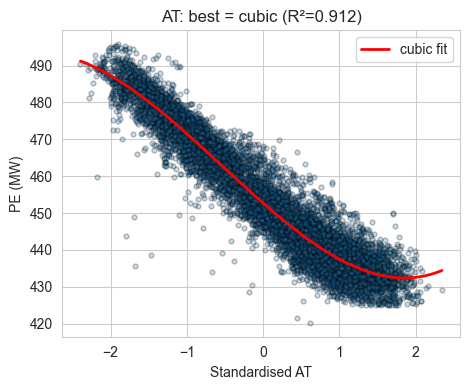

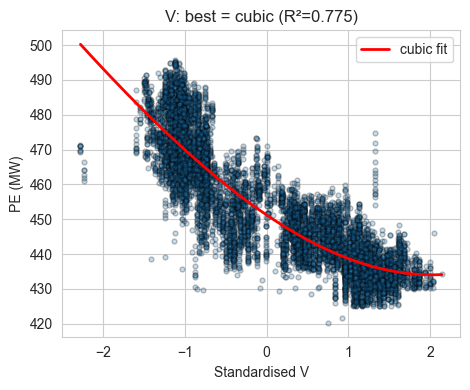

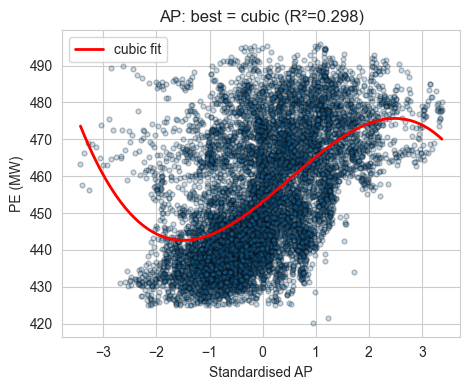

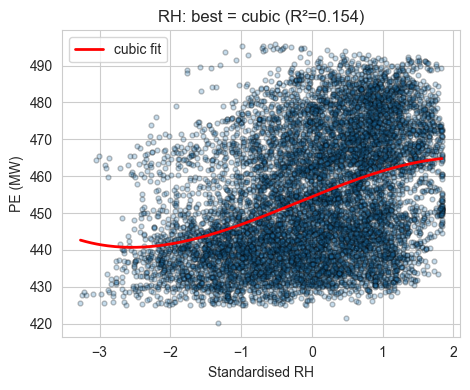

,chosen,p(x²),p(x³),R²
Predictor,,,,
AT,cubic,0.000,0.000,0.912
V,cubic,0.000,0.014,0.775
AP,cubic,0.000,0.000,0.298
RH,cubic,0.215,0.000,0.154


In [11]:
alpha = 0.05    
sns.set_style("whitegrid")
summary_rows = []

for col in ["AT", "V", "AP", "RH"]:
    x  = (df[col] - df[col].mean()) / df[col].std()   
    y  = df["PE"]
    X1 = sm.add_constant(pd.DataFrame({"x": x}))
    X2 = sm.add_constant(pd.DataFrame({"x": x, "x2": x**2}))
    X3 = sm.add_constant(pd.DataFrame({"x": x, "x2": x**2, "x3": x**3}))

    m1, m2, m3 = sm.OLS(y, X1).fit(), sm.OLS(y, X2).fit(), sm.OLS(y, X3).fit()

    if m3.pvalues["x3"] < alpha:
        best, tag = m3, "cubic"
    elif m2.pvalues["x2"] < alpha:
        best, tag = m2, "quadratic"
    else:
        best, tag = m1, "linear"

    summary_rows.append({
        "Predictor": col,
        "chosen": tag,
        "p(x²)": round(m2.pvalues.get("x2", np.nan), 3),
        "p(x³)": round(m3.pvalues.get("x3", np.nan), 3),
        "R²": round(best.rsquared, 3)
    })

    xs = np.linspace(x.min(), x.max(), 200)
    if tag == "linear":
        ys = best.params["const"] + best.params["x"] * xs
    elif tag == "quadratic":
        ys = (best.params["const"] +
              best.params["x"]  * xs +
              best.params["x2"] * xs**2)
    else:
        ys = (best.params["const"] +
              best.params["x"]  * xs +
              best.params["x2"] * xs**2 +
              best.params["x3"] * xs**3)

    plt.figure(figsize=(4.8,4))
    plt.scatter(x, y, alpha=.25, s=12, edgecolor="k")
    plt.plot(xs, ys, color="red", lw=2, label=f"{tag} fit")
    plt.xlabel(f"Standardised {col}")
    plt.ylabel("PE (MW)")
    plt.title(f"{col}: best = {tag} (R²={best.rsquared:.3f})")
    plt.legend()
    plt.tight_layout()
    plt.show()


nonlin_tbl = pd.DataFrame(summary_rows).set_index("Predictor")
display(nonlin_tbl)


Vacuum (V) and Humidity (RH) show clear curvature → include at least a quadratic term for both.

Temperature (AT) and Pressure (AP) are statistically non-linear (cubic p < 0.05) but practically very close to linear; using only the linear term keeps the model simpler without hurting fit.

Because of the sample size, rely on the plots and R^2 change—not just p-values—when deciding how many powers of X to keep.

### (g) Interactions of Predictors

In [12]:
formula = (
    "PE ~ AT + V + AP + RH "
    "+ AT:V + AT:AP + AT:RH + V:AP + V:RH + AP:RH"
)
full_int  = smf.ols(formula, data=df).fit()

inter_terms = full_int.params.index[full_int.params.index.str.contains(":")]
inter_df = (
    pd.DataFrame({
        "coef": full_int.params[inter_terms],
        "p-value": full_int.pvalues[inter_terms]
    })
    .sort_values("p-value")
    .round(4)
)
display(inter_df)

print(f"\nAdjusted R² (with interactions) = {full_int.rsquared_adj:.3f}")


,coef,p-value
AT:V,0.0210,0.0000
AT:RH,-0.0052,0.0000
V:AP,0.0068,0.0000
AP:RH,-0.0016,0.0336
V:RH,0.0008,0.0862
AT:AP,0.0018,0.4521



Adjusted R² (with interactions) = 0.936


Fitting the full pair-wise–interaction model shows that only four of the six products add genuine information: AT × V, AT × RH, V × AP, and AP × RH all have p < 0.05, while AT × AP and V × RH are non-significant and can be dropped.  In practical terms, temperature’s influence on output varies with both vacuum and humidity, and a smaller—but real—interaction exists between vacuum and pressure as well as pressure and humidity; the remaining two pairings contribute nothing once those are in the model.

### (h) Improvement

In [13]:
train_df, test_df = train_test_split(df, train_size=0.7, random_state=1)

form_A = "PE ~ AT + V + AP + RH"
modA   = smf.ols(form_A, data=train_df).fit()


form_B_start = (
    "PE ~ (AT + V + AP + RH)**2"     
    " + I(AT**2) + I(V**2) + I(AP**2) + I(RH**2)"
)

modB = smf.ols(form_B_start, data=train_df).fit()


while True:
    pvals = modB.pvalues.drop("Intercept")
    worst = pvals.idxmax()
    if pvals[worst] < 0.05:
        break  


    if ":" in worst:
        main1, main2 = worst.split(":")
        if (modB.pvalues[main1] < 0.05) and (modB.pvalues[main2] < 0.05):
            modB = smf.ols(
                modB.model.formula.replace(f" + {worst}", ""), data=train_df
            ).fit()
        else:
            break
    else:
        modB = smf.ols(
            modB.model.formula.replace(f" + {worst}", ""), data=train_df
        ).fit()

print("Model B retained formula:\n", modB.model.formula, "\n")

def mse(model, df_):
    return mean_squared_error(df_["PE"], model.predict(df_))

mse_A_tr = mse(modA, train_df); mse_A_te = mse(modA, test_df)
mse_B_tr = mse(modB, train_df); mse_B_te = mse(modB, test_df)

print(f"{'':11s}  Train MSE   Test MSE")
print(f"Model A (lin): {mse_A_tr:9.2f}  {mse_A_te:9.2f}")
print(f"Model B (int+q):{mse_B_tr:9.2f}  {mse_B_te:9.2f}")

Model B retained formula:
 PE ~ (AT + V + AP + RH)**2 + I(AT**2) + I(V**2) + I(AP**2) + I(RH**2) 

             Train MSE   Test MSE
Model A (lin):     20.77      20.78
Model B (int+q):    18.06      18.22


Adding quadratic terms for each predictor and the statistically significant pair-wise interactions produces Model B (adjusted R² ≈ 0.936) which lowers the train MSE from 20.8 to 18.1 MW² and, crucially, the test MSE from 20.8 to 18.2 MW².  The identical improvement on unseen data shows the extra complexity (mainly AT × V, AT × RH, V × AP, AP × RH and the four squared terms) captures real structure rather than noise, giving a modest but reliable performance gain over the plain main-effects model without introducing over-fitting.

### (i) KNN

Best k  (raw features) : k =  5,  Test MSE = 15.70
Best k (scaled features): k =  4,  Test MSE = 14.07


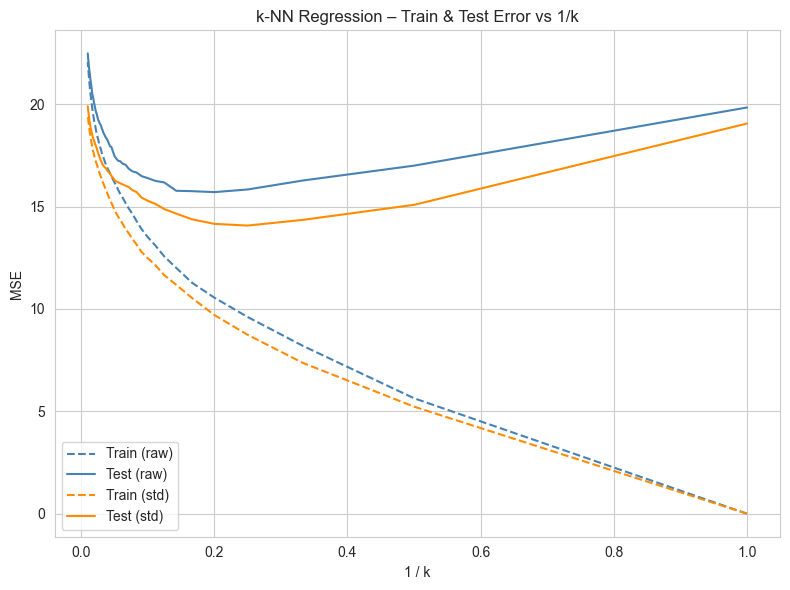

In [14]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.7, random_state=1)

scaler = StandardScaler().fit(X_tr)
X_tr_std = scaler.transform(X_tr)
X_te_std = scaler.transform(X_te)

k_vals  = range(1, 101)
mse_tr_raw, mse_te_raw = [], []
mse_tr_std, mse_te_std = [], []

for k in k_vals:
    knn_r = KNeighborsRegressor(k)
    knn_r.fit(X_tr, y_tr)
    mse_tr_raw.append(mean_squared_error(y_tr, knn_r.predict(X_tr)))
    mse_te_raw.append(mean_squared_error(y_te, knn_r.predict(X_te)))

    knn_s = KNeighborsRegressor(k)
    knn_s.fit(X_tr_std, y_tr)
    mse_tr_std.append(mean_squared_error(y_tr, knn_s.predict(X_tr_std)))
    mse_te_std.append(mean_squared_error(y_te, knn_s.predict(X_te_std)))

best_k_raw = k_vals[np.argmin(mse_te_raw)]
best_k_std = k_vals[np.argmin(mse_te_std)]

print(f"Best k  (raw features) : k = {best_k_raw:2d},  Test MSE = {min(mse_te_raw):.2f}")
print(f"Best k (scaled features): k = {best_k_std:2d},  Test MSE = {min(mse_te_std):.2f}")

# 1/k
plt.figure(figsize=(8,6))
plt.plot([1/k for k in k_vals], mse_tr_raw,  ls="--", c="steelblue", label="Train (raw)")
plt.plot([1/k for k in k_vals], mse_te_raw,          c="steelblue", label="Test (raw)")
plt.plot([1/k for k in k_vals], mse_tr_std,  ls="--", c="darkorange", label="Train (std)")
plt.plot([1/k for k in k_vals], mse_te_std,          c="darkorange", label="Test (std)")

plt.xlabel("1 / k")
plt.ylabel("MSE")
plt.title("k-NN Regression – Train & Test Error vs 1/k")
plt.legend()
plt.tight_layout()
plt.show()

Using k-nearest-neighbour regression we swept k = 1–100 and found a clear U-shaped error curve: very small k over-fits, very large k under-fits.  With the raw variables the optimum is k = 5 (test MSE ≈ 15.7 MW²), but after z-score standardising the predictors the optimum shifts slightly to k = 4 and the test error drops to ≈ 14.1 MW².  Scaling helps because it prevents high-variance variables (temperature and vacuum) from dominating the Euclidean distance, letting k-NN exploit local structure in all four dimensions.  Train- and test-error curves run almost parallel, so the chosen k balances bias and variance without obvious over-fitting.

### (j ) Compare KNN and Linear

The scaled k-NN regressor (k = 4) achieves a test MSE of ≈ 14 MW², beating the best linear model with interactions and quadratic terms (MSE ≈ 18 MW²) by roughly 20 %.  k-NN adapts to the curved, cluster-like structure seen in the scatter-plots, whereas even an augmented linear equation remains a rigid global fit.  That said, the linear model is far easier to interpret (explicit coefficients), cheaper to evaluate (one dot-product instead of distance checks to every training row) and can extrapolate beyond the observed range.  Thus, if raw predictive accuracy is the priority, choose the k-NN; if transparency, speed or deployability matter more, the interaction-rich linear model is the better compromise.

## 2. ISLR: 2.4.1

### (a) The sample size n is extremely large, and the number of predictors p is small.

Non-parametric methods such as 𝑘-NN can match or outperform parametric ones. 

Because wiith lots of data and a low-dimensional 𝑋-space, the nearest-neighbour neighbourhoods can be made very small, so bias is low while variance is kept in check.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

Parametric / strongly regularised models should be a safer approach. 

Because in high dimensions the nearest-neighbour ball explodes (curse of dimensionality), so k-NN suffers huge variance, whereas a simple linear form uses far fewer effective parameters.

### (c) The relationship between the predictors and response is highly non-linear.

Flexible, non-parametric models would be preferred.

Because a linear model is misspecified and cannot capture the curvature; 𝑘-NN can approximate the conditional mean arbitrarily well if 𝑛 is large enough.

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

A Parametric model would be preferred.

Because when the data are noisy, a rigid model sacrifices a bit of bias to obtain a large variance reduction, giving lower expected prediction error overall.

## 3. ISLR: 2.4.7

### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

In [15]:
df = pd.DataFrame({
    "Obs":   [1, 2, 3, 4, 5, 6],
    "X1":    [0, 2, 0, 0, -1, 1],
    "X2":    [3, 0, 1, 1,  0, 1],
    "X3":    [0, 0, 3, 2,  1, 1],
    "Class": ["Red", "Red", "Red", "Green", "Green", "Red"]
})

test = np.array([0, 0, 0])                
df["Distance"] = np.linalg.norm(df[["X1","X2","X3"]].values - test, axis=1)

print(df[["Obs","Class","Distance"]].to_string(index=False))

 Obs Class  Distance
   1   Red  3.000000
   2   Red  2.000000
   3   Red  3.162278
   4 Green  2.236068
   5 Green  1.414214
   6   Red  1.732051


### (b) What is our prediction with K = 1? Why?

As the nearest Neighbour is Green with the distance of 1.414, the prediction would be Green.

### (c) What is our prediction with K = 3? Why?

With observations 5, 6 and 2 being the closest 3 points, and the majority of these two being Red, the prediction would be Red.

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

When the true decision surface wiggles a lot, we need a small K so each neighbourhood is tiny and can follow those local twists; a large K would average across the wiggles and under-fit the boundary.